In [1]:
#Todo: 
#* threshold motif scores at 0 
#* PRC curves --> Merged in this notebooks. 




# How to train your DragoNN tutorial 3: 
## Interpreting features induced by DNN's across multiple types of motif grammars 

This tutorial is a supplement to the DragoNN manuscript and follows figure 7 in the manuscript. 

This tutorial will take 1 hour  if executed on a GPU. 

Please complete "Primer Tutorial 1- Exploring model architectures for a homotypic motif density simulation" prior to completing this tutorial. 

The architectures used in this tutorial were determined as optimal by hyperparameter grid search in "Primer Tutorial 3 - CNN Hyperparameter Tuning via Grid Search"


## Outline<a name='outline'>
<ol>
    <li><a href=#1>How to use this tutorial</a></li>
    <li><a href=#2>Defining helper functions for model training and interpretation</a></li>
    TODO: explain reference options. 
    <li><a href=#3>Simulating training data with simdna: Review of Tutorial 1</a></li>
    <li><a href=#4>Single Motif</a></li>
    <li><a href=#5>Homotypic motif density detection</a></li>
    <li><a href=#6>Homotypic motif density localization</a></li>
    <li><a href=#7>Multiple motifs (multi-task)</a></li>  
    <li><a href=#8>Heterotypic motifs spatial grammar</a></li>
    <li><a href=#9>Conclusions</a></li>
</ol>
Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.

 

## How to use this tutorial<a name='1'>
<a href=#outline>Home</a>

This tutorial utilizes a Jupyter/IPython Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](./tutorial_images/play_button.png)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](./tutorial_images/play_all_button.png)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](./tutorial_images/inspecting_code.png)


In [1]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install dragonn>=0.2.7

In [1]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers import Dropout, Reshape, Dense, Activation, Flatten,BatchNormalization,Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')
import numpy as np 

We start by loading dragonn's tutorial utilities.

In [2]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Defining helper functions for model training and interpretation  <a name='2'>
<a href=#outline>Home</a>


For each type of simulation, we will perform a consistent set of tasks: 
* Define the optimal model architecture, as determined in Tutorial 2. This architecture will be specific to the simulation used, so we don't write a universal helper function for this purpose. 
* Train the model on simulation data and visualize the model's learning curve on training and validation data. 
* Compute the model's performance on a held-out test set.
* Visualize motif scores for a positive and negative example. 
* Perform in silico mutagenesis for a positive and negative example.
* Compute DeepLIFT scores for a positive and negative example.

To avoid writing the same code for each scenario, we define a series of helpers functions to perform the tasks above. 

In [12]:
from dragonn.callbacks import * 
from dragonn.vis import plot_learning_curve

def train_model(model,data):
    #We define a custom callback to print training and validation metrics while training. 
    metrics_callback=MetricsCallback(train_data=(data.X_train,data.y_train),validation_data=(data.X_valid,data.y_valid))
    
    #Train the model 
    history=model.fit(x=data.X_train,
                      y=data.y_train,
                      batch_size=128,
                      epochs=150,
                      verbose=0,
                      callbacks=[EarlyStopping(patience=3,restore_best_weights=True),
                                metrics_callback],
                                validation_data=(data.X_valid,data.y_valid))
    
    #Visualize the model's performance curve 
    plot_learning_curve(history)
    return model

In [5]:
#Compute model performance on a held out test set 
def compute_performance(model,data):
    test_predictions=model.predict(data.X_test)
    ## Generate a ClassificationResult object to print performance metrics on held-out test set 
    print(ClassificationResult(data.y_test,test_predictions))


In [3]:
def extract_pos_and_neg_samples(data,n=None):
#split training, validation, test data into positive and negative subsets 
# if n is provided, the first n positive and negative samples will be selected from each split 
    if n is None: 
        n=data.shape[0]
    train_pos_index=np.flatnonzero(data.y_train==1)
    train_pos_X=data.X_train[train_pos_index][0:n]
    train_neg_index=np.flatnonzero(data.y_train==0)
    train_neg_X=data.X_train[train_neg_index][0:n]
    
    valid_pos_index=np.flatnonzero(data.y_valid==1)
    valid_pos_X=data.X_valid[valid_pos_index][0:n]
    valid_neg_index=np.flatnonzero(data.y_valid==0)
    valid_neg_X=data.X_valid[valid_neg_index][0:n]
    
    test_pos_index=np.flatnonzero(data.y_test==1)
    test_pos_X=data.X_test[test_pos_index][0:n]
    test_neg_index=np.flatnonzero(data.y_test==0)
    test_neg_X=data.X_test[test_neg_index][0:n]
    
    return train_pos_X,train_neg_X, valid_pos_X, valid_neg_X, test_pos_X, test_neg_X

In [14]:
#Run the full data analysis for a given dataset and model 
#Train the model, compute it's performance on a positive and negative data point 
from dragonn.interpret import * 
def analyze(model,data,pos_index,neg_index,outfname,motif_names,xlim_for_plot,n_to_interpret=None):
    
    '''
    model -- keras model object 
    data -- simulated dataset object 
    pos_index -- numberical index of positive test example (within the data object) that should be interpreted 
    neg_index -- numberical index of negative test eample (within the data object) that should be interpreted 
    outfname -- name of output file to save the keras model 
    motif_names -- list of motif names used in the simulation 
    xlim_for_plot -- tuple indicating start and end x-coordinates of sequence example (0-indexed) to show in interpretation plot 
    n_to_interpet -- number of test samples to interpet
    Returns: 
    pos_interpretation -- dictionary of interpretation metrics for positive examples in the test set 
    neg_interpretation -- dictionary of interpretation metrics for negative examples in the test set 
    
    '''
    
    #Train the model
#     model=train_model(model,data)
#     #Compute model performance on a held-out test set 
#     compute_performance(model,data)
#     #save the model to an output file 
#     model.save(outfname)
    #Extract positive and negative examples for interpretation 
    train_pos_X,train_neg_X, valid_pos_X, valid_neg_X, test_pos_X, test_neg_X=extract_pos_and_neg_samples(data,n_to_interpret)
    #Get the deepLIFT scoring function

    #perform interpretation on the test set 
    test_pos_interpretations=multi_method_interpret(model,
                                           test_pos_X,
                                           0,
                                           motif_names=motif_names,
                                           generate_plots=False)
    
    test_neg_interpretations=multi_method_interpret(model,
                                           test_neg_X,
                                           0,
                                           motif_names=motif_names,
                                           generate_plots=False)
    
    return test_pos_X,test_neg_X,test_pos_interpretations,test_neg_interpretations 


Finally, we set a random seed to ensure that all analyses in this tutorial are reproducible. 

In [5]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow.random import set_seed
set_seed(1234)

## Getting simulation data <a name='3'>
<a href=#outline>Home</a>


DragoNN provides a set of simulation functions. Let's use the **print_available_simulations** function to examine the list of simulations supported by DragoNN:

In [6]:
from dragonn.simulations import * 
print_available_simulations()

simulate_differential_accessibility
simulate_heterodimer_grammar
simulate_motif_counting
simulate_motif_density_localization
simulate_multi_motif_embedding
simulate_single_motif_detection


## Single Motif <a name='4'>
<a href=#outline>Home</a>


We begin with single motif detection of the TAL1_known4 motif: 

![play button](./tutorial_images/TAL1_known4.png)
Let's find out what parameters are needed for the simulation: 

In [7]:
print_simulation_info("simulate_single_motif_detection")


    Simulates two classes of seqeuences:
        - Positive class sequence with a motif
          embedded anywhere in the sequence
        - Negative class sequence without the motif

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Array with sequence strings.
    y : 1darray
        Array with positive/negative class labels.
    embedding_arr: 1darray
        Array of embedding objects.
    


In this binary simulation task, we simulate a negative set of 10K 500 bp random sequences and a positive set of 10K 500 bp random sequences with one instance of the TAL1 motif randomly embedded at any position.

In [8]:
#Define simulation parameters 
tal1_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 500, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data 
tal1_data = get_simulation_data("simulate_single_motif_detection",
                                      tal1_parameters,
                                      validation_set_size=3200, test_set_size=4000)


We define the convolutional neural network model architecture: 

In [9]:
#Define the optimal model architecture in keras (Refer to Primer Tutorial 2)
tal1_model=Sequential() 
tal1_model.add(Conv2D(filters=10,kernel_size=(1,15),input_shape=tal1_data.X_train.shape[1::]))
tal1_model.add(Activation('relu'))
tal1_model.add(MaxPooling2D(pool_size=(1,35)))
tal1_model.add(Flatten())
tal1_model.add(Dense(1))
tal1_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
tal1_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

2022-06-30 11:07:01.807789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-30 11:07:04.849666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11487 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:09:00.0, compute capability: 5.2


## test cell

In [10]:
from keras.models import load_model
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tal1_model=load_model("tut3_single_motif_detection.hdf5")

2022-06-30 11:07:07.637798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11487 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:09:00.0, compute capability: 5.2
2022-06-30 11:07:07.735630: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [15]:
#note: ISM is quite slow, so we select 50 samples for interpretation 
n_to_interpret=1
single_motif_pos_X,single_motif_neg_X, single_motif_pos_interpretations, single_motif_neg_interpretations = analyze(tal1_model,tal1_data,1,1,"tut3_single_motif_detection.hdf5",["TAL1_known4"],(0,500),n_to_interpret=n_to_interpret)



getting 'motif_scan' value
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deepshap' value

Done 0 examples of 1
getting 'motif_scan' value
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deepshap' value
Done 0 examples of 1


Let's zoom in to the portion of the interpretation track with the strongest signal:

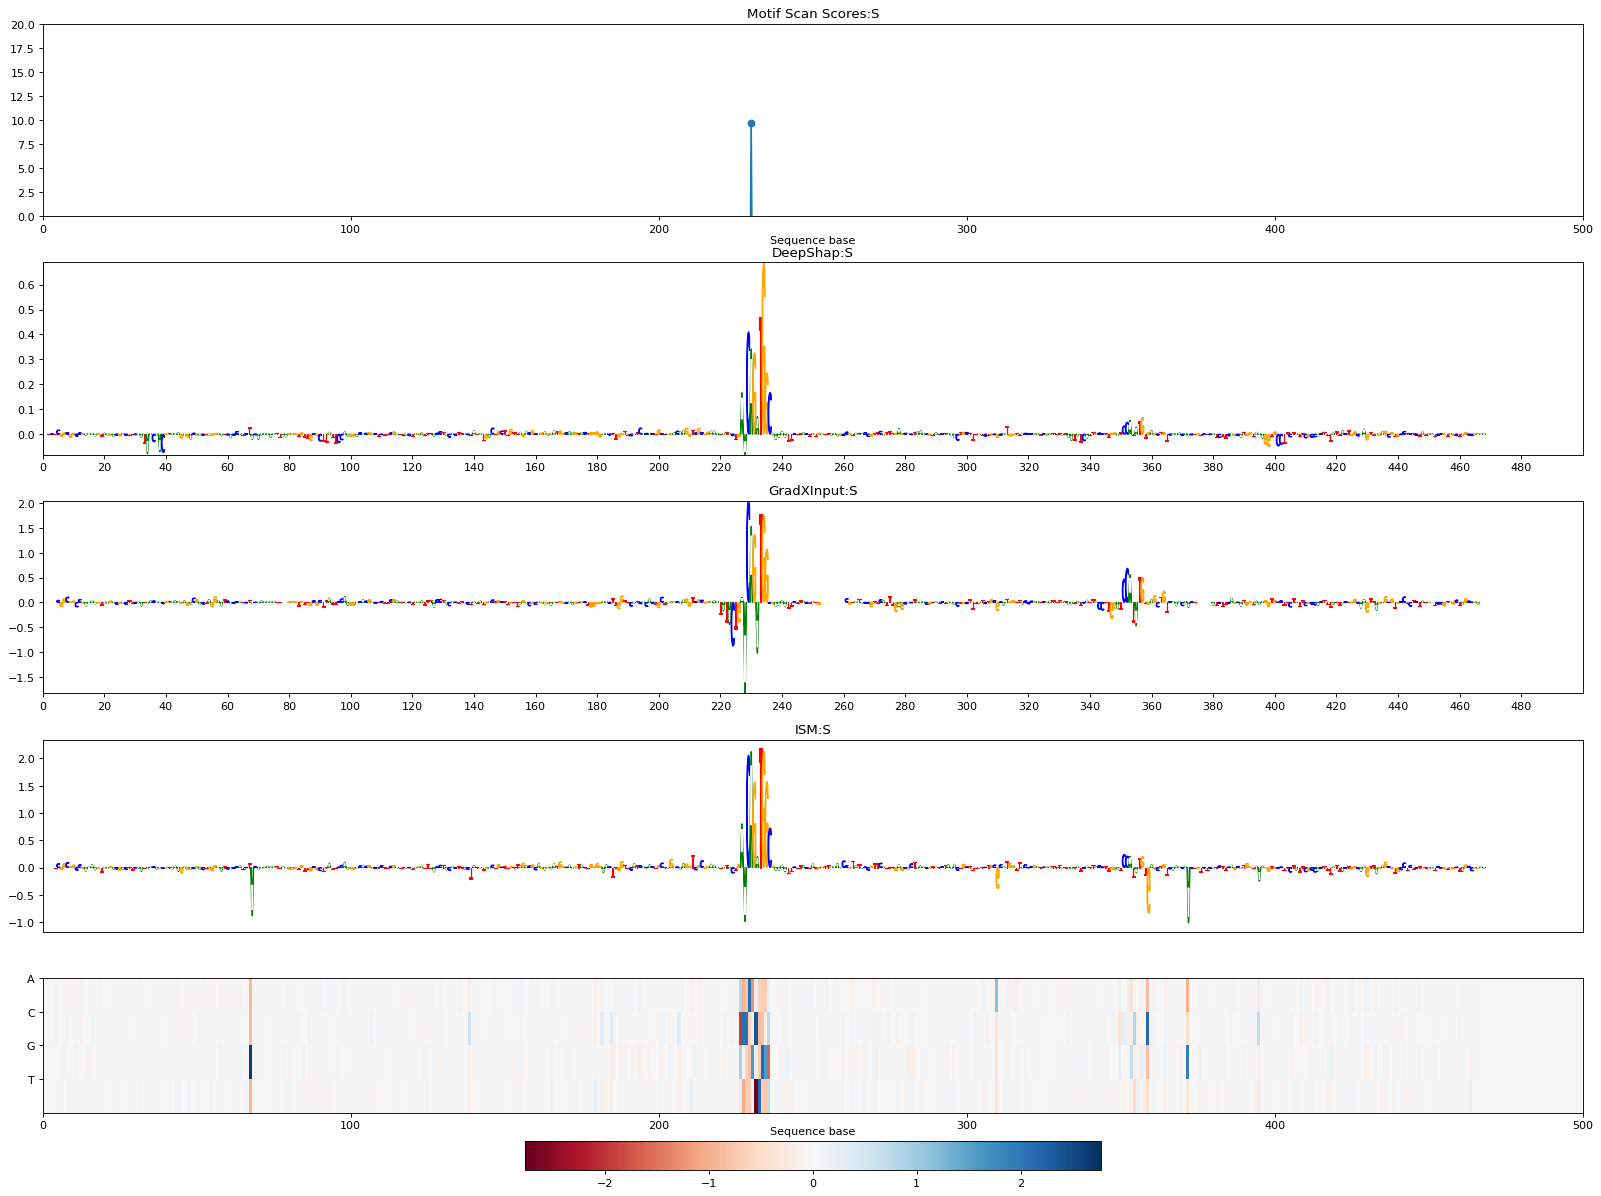

In [40]:
%matplotlib inline
from dragonn.vis import * 
plot_all_interpretations([single_motif_pos_interpretations],
                         single_motif_pos_X,
                         title="Single Motif, Positive",
                         index=0)


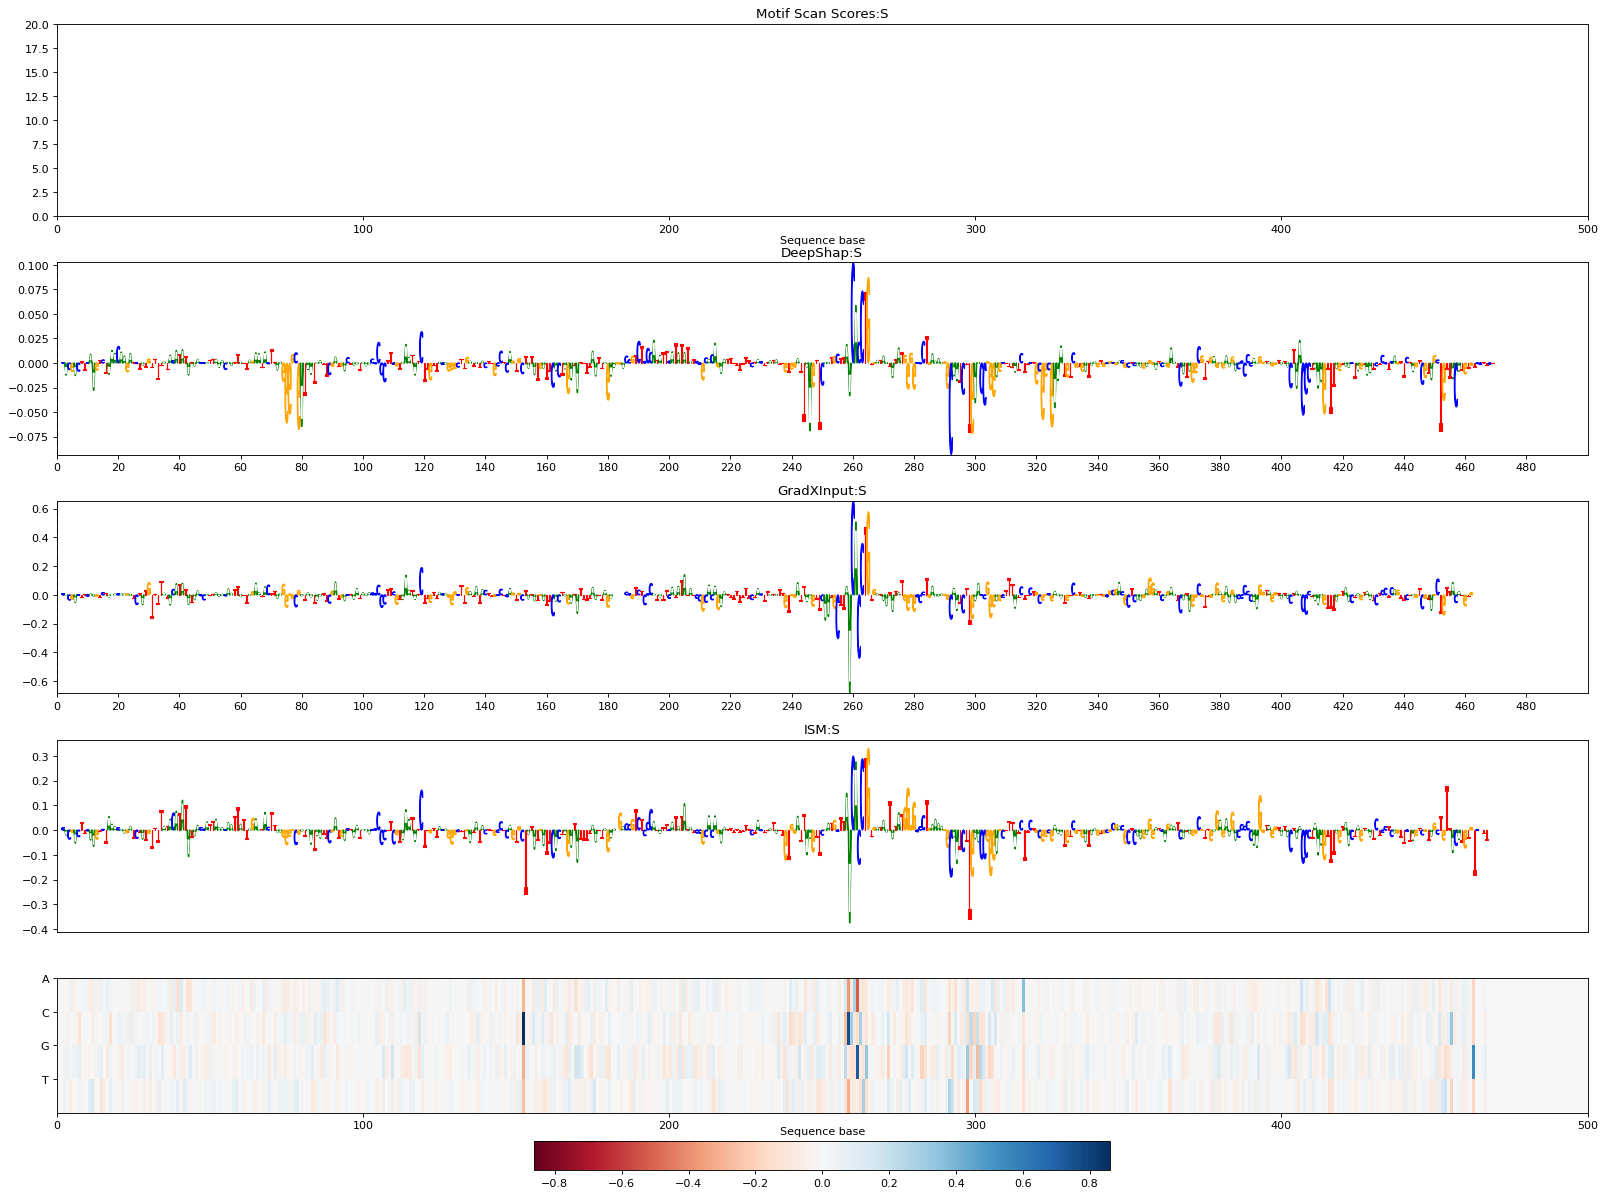

In [41]:
plot_all_interpretations([single_motif_neg_interpretations],
                         single_motif_neg_X,
                         title="Single Motif, Negative",
                         index=0)


In [37]:
from dragonn.positional_prc import * 
motif_score_posPRC=positionalPRC(tal1_data.test_embeddings[0:n_to_interpret],single_motif_pos_interpretations['motif_scan'])
motif_score_posPRC=positionalPRC(tal1_data.test_embeddings[0:n_to_interpret],single_motif_pos_interpretations['motif_scan'])


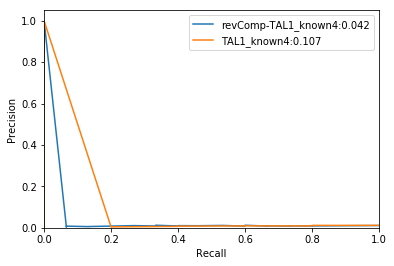

In [43]:
from dragonn.vis import plot_positionalPRC
plot_positionalPRC(motif_score_posPRC)

## Homotypic motif density detection <a name='5'>
<a href=#outline>Home</a>

In [ ]:
#Define simulation parameters 
density_detection_parameters={
    "motif_name": "TAL1_known4",
    "seq_length": 500,
    "neg_counts":[0,2],
    "pos_counts":[3,5],
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data
density_detection_data=get_simulation_data("simulate_motif_counting",
                               density_detection_parameters,
                               validation_set_size=3200,test_set_size=4000)



In [ ]:
#Define the optimal model architecture in keras (Refer to Primer Tutorial 2)
density_detection_model=Sequential() 
density_detection_model.add(Conv2D(filters=10,kernel_size=(1,15),input_shape=density_detection_data.X_train.shape[1::]))
density_detection_model.add(Activation('relu'))
density_detection_model.add(MaxPooling2D(pool_size=(1,35)))
density_detection_model.add(Flatten())
density_detection_model.add(Dense(1))
density_detection_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
density_detection_model.compile(optimizer='adam',
                               loss='binary_crossentropy')


In [ ]:
density_detection_pos_X,density_detection_neg_X,density_detection_pos_interpretations,density_detection_neg_interpetations=analyze(density_detection_model,density_detection_data,
                                             1,
                                             1,
                                             "tut3_density_detection.hdf5",
                                             ["TAL1_known4"],
                                             (0,500))

## Homotypic motif density localization <a name='6'>
<a href=#outline>Home</a>

In [ ]:
#Define simulation parameters 
density_localization_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1000,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
density_localization_data=get_simulation_data("simulate_motif_density_localization",
                               density_localization_parameters,
                               validation_set_size=3200,test_set_size=4000)



In [ ]:
#Define the optimal model architecture in keras (Refer to Primer Tutorial 2)
density_localization_model=Sequential() 
density_localization_model.add(Conv2D(filters=5,kernel_size=(1,10),input_shape=density_localization_data.X_train.shape[1::]))
density_localization_model.add(Activation('relu'))
density_localization_model.add(MaxPooling2D(pool_size=(1,10)))
density_localization_model.add(Flatten())
density_localization_model.add(Dense(1))
density_localization_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
density_localization_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

In [ ]:
pos_X, neg_X, ism_pos, ism_neg, gradinput_pos, gradinput_neg, dl_pos, dl_neg=analyze(density_localization_model,density_localization_data,1,1)

In [ ]:
plot_seq_importance(dl_pos,pos_X,xlim=(220,275),title="Positive")
plot_seq_importance(dl_neg,neg_X,xlim=(220,275),title="Negative")

## Multiple motifs (multi-task)<a name='7'>
<a href=#outline>Home</a>

In [ ]:
#Define simulation parameters 
multi_motif_parameters = {
    "motif_names": ["CTCF_known1","ZNF143_known2","SIX5_known1"],
    "seq_length": 500,
    "min_num_motifs": 0,
    "max_num_motifs": 1, 
    "num_seqs": 20000,
    "GC_fraction": 0.4}

#Get simulation data
multi_motif_data=get_simulation_data("simulate_multi_motif_embedding",
                               multi_motif_parameters,
                               validation_set_size=3200,test_set_size=4000)



In [ ]:
#Define the optimal model architecture in keras (Refer to Primer Tutorial 2)
multi_motif_model=Sequential() 
multi_motif_model.add(Conv2D(filters=20,kernel_size=(1,20),input_shape=multi_motif_data.X_train.shape[1::]))
multi_motif_model.add(Activation('relu'))
multi_motif_model.add(MaxPooling2D(pool_size=(1,10)))
multi_motif_model.add(Flatten())
multi_motif_model.add(Dense(3))
multi_motif_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
multi_motif_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

In [ ]:
pos_X, neg_X, ism_pos, ism_neg, gradinput_pos, gradinput_neg, dl_pos, dl_neg=analyze(multi_motif_model, multi_motif_data,1,1)

In [ ]:
plot_seq_importance(dl_pos,pos_X,xlim=(220,275),title="Positive")
plot_seq_importance(dl_neg,neg_X,xlim=(220,275),title="Negative")

## Heterotypic motifs spatial grammar<a name='8'>
<a href=#outline>Home</a>

In [ ]:
#Define simulation parameters 
heterodimer_parameters = {
    "motif1": "SPI1_known4",
    "motif2": "IRF_known1",
    "seq_length": 500,
    "min_spacing": 2,
    "max_spacing": 5, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
heterodimer_data=get_simulation_data("simulate_heterodimer_grammar",
                               heterodimer_parameters,
                               validation_set_size=3200,test_set_size=4000)

In [ ]:
heterodimer_model=Sequential()
heterodimer_model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
heterodimer_model.add(Activation("relu"))
heterodimer_model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
heterodimer_model.add(Activation("relu"))
heterodimer_model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
heterodimer_model.add(Activation("relu"))
heterodimer_model.add(MaxPooling2D(pool_size=(1,35)))    
heterodimer_model.add(Flatten())
heterodimer_model.add(Dense(num_tasks))
heterodimer_model.add(Activation("sigmoid"))
heterodimer_model.compile(optimizer='adam',loss='binary_crossentropy')


In [ ]:
pos_X, neg_X, ism_pos, ism_neg, gradinput_pos, gradinput_neg, dl_pos, dl_neg=analyze(heterodimer_model,heterodimer_data,1,1)

In [ ]:
plot_seq_importance(dl_pos,pos_X,xlim=(220,275),title="Positive")
plot_seq_importance(dl_neg,neg_X,xlim=(220,275),title="Negative")

## Conclusions<a name='9'>
<a href=#outline>Home</a>